In [1]:
from __future__ import print_function
from __future__ import absolute_import
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

Pysaliency
==========

Saliency Map Models
----------------------

`pysaliency` comes with a variety of features to evaluate saliency map models. This notebooks demonstrates these features.

First we load the MIT1003 dataset:

In [2]:
import sys
import pysaliency
from pysaliency.external_datasets.sjtuvis import TextDescriptor

data_location = "../../datasets/test"
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
print(text_descriptor.get_description('000000020777_2.png')) 
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis("../../datasets/test/original_sjtuvis_dataset", location=data_location, text_descriptor=text_descriptor)

A fireman stood at the top of the ladder


In [3]:
# import matplotlib.pyplot as plt
# import random
# num_rows = 4
# num_cols = 5

# # Create a figure and subplots
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
# # print(mit_stimuli, mit_stimuli.stimuli[0])


# for i, ax in enumerate(axes.flat):
#     # Get the image and fixations for the current index
#     index = random.randint(0, len(mit_stimuli.stimuli) - 1)
    
#     image = mit_stimuli.stimuli[index]
#     fixations = mit_fixations[mit_fixations.n == index]
#     # Plot the image
#     ax.imshow(image)
#     ax.axis('off')

#     # Plot the fixations as red dots
#     ax.scatter(fixations.x, fixations.y, color='r')

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

As some evaluation methods can take quite a long time to run, we prepare a smaller dataset consisting of only the first 10 stimuli:

We will use the saliency model *AIM* by Bruce and Tsotos

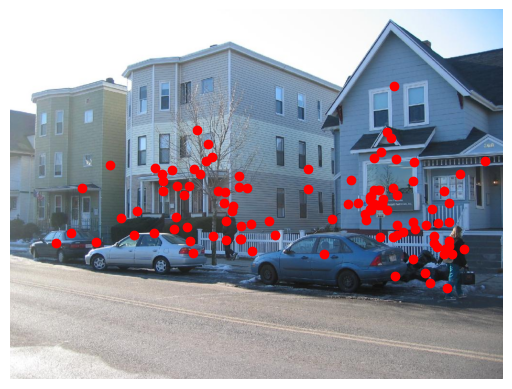

In [4]:
data_location = "../../datasets"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_mit1003(location=data_location)
index = 10
plt.imshow(mit_stimuli.stimuli[index])
f = mit_fixations[mit_fixations.n == index]
plt.scatter(f.x, f.y, color='r')
_ = plt.axis('off')
cutoff = 20

aim: pysaliency.SaliencyMapModel = pysaliency.AIM(location='../../models', cache_location=os.path.join('model_caches', 'AIM'))

from pysaliency.external_datasets.sjtuvis import TextDescriptor
text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
data_location = "../../datasets/test"
original_dataset_path = "../../datasets/test/original_sjtuvis_dataset"
mit_stimuli, mit_fixations = pysaliency.external_datasets.get_sjtu_vis(original_dataset_path=original_dataset_path, location=data_location, text_descriptor = text_descriptor)
short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
short_fixations = mit_fixations[mit_fixations.n < cutoff]

# gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
# image_based_kl = aim.image_based_kl_divergence(short_stimuli, gold_standard)
    

# import matplotlib.pyplot as plt


# smap = aim.saliency_map(mit_stimuli[10])
# print(smap.shape, mit_stimuli[10].shape, type(smap), smap.shape, np.min(smap), np.max(smap))

# plt.imshow(image)
# plt.axis('off')
# plt.show()

# plt.imshow(-smap)
# print(smap.shape, mit_stimuli[10].shape, type(smap), smap.shape, np.min(smap), np.max(smap))
# plt.axis('off')

# num_rows = 2
# num_cols = 3
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))0
# for i, ax in enumerate(axes.flat):
#     index = i  # Replace with your desired index
#     image = mit_stimuli.stimuli[index]
#     print(image.shape)
#     saliency_map = aim.saliency_map(image)
#     # ax.imshow(image)
#     ax.axis('off')
#     ax.imshow(-saliency_map)
# plt.tight_layout()
# plt.show()

Lavis text guided saliency model. Loaded from the lavis module. 😎 😎 😎

In [5]:
import torch
from PIL import Image
from lavis.models import load_model_and_preprocess
from lavis.processors import load_processor
from matplotlib import pyplot as plt
from lavis.common.gradcam import getAttMap
from lavis.models.blip_models.blip_image_text_matching import compute_gradcam
import numpy as np
from pysaliency.datasets import Stimulus, Fixations,  StimuliStimulus
import pysaliency

def handle_stimulus(stimulus):
    """
    Make sure that a stimulus is a `Stimulus`-object
    """
    if not isinstance(stimulus, Stimulus):
        stimulus = Stimulus(stimulus)
    return stimulus

import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import face
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch

import deepgaze_pytorch    
from typing import Optional, Tuple, List, Dict, Any, Union, Sequence
import pysaliency
DEVICE = 'cuda'

class DeepGazeSaliencyModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, block_num=7, dst_w=720, version = 1):
        super().__init__()
        if version == 1:
            self.model = deepgaze_pytorch.DeepGazeI(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 2:
            self.model = deepgaze_pytorch.DeepGazeIIE(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = False
        elif version == 3:
            self.model = deepgaze_pytorch.DeepGazeIII(pretrained=True).to(DEVICE)
            self.use_hist_scan_path = True
        self.block_num = block_num
        self.dst_w = dst_w
        
    def _saliency_map(self, stimulus, text_description:Optional[str]=None):
        image = stimulus
        # print("The input image....")
        # print(image.shape, image.dtype, np.min(image), np.max(image))
        fixation_history_x = np.array([1024//2, 300, 500, 200, 200, 700])
        fixation_history_y = np.array([768//2, 300, 100, 300, 100, 500])

        centerbias_template = np.load('../../pretrained_weights/deepgaze/centerbias_mit1003.npy')
        centerbias = zoom(centerbias_template, (image.shape[0]/centerbias_template.shape[0], image.shape[1]/centerbias_template.shape[1]), order=0, mode='nearest')
        centerbias -= logsumexp(centerbias)

        image_tensor = torch.tensor([image.transpose(2, 0, 1)]).to(DEVICE)
        centerbias_tensor = torch.tensor([centerbias]).to(DEVICE)

        if self.use_hist_scan_path:
            x_hist_tensor = torch.tensor([fixation_history_x[self.model.included_fixations]]).to(DEVICE)
            y_hist_tensor = torch.tensor([fixation_history_y[self.model.included_fixations]]).to(DEVICE)
            log_density_prediction = self.model(image_tensor, centerbias_tensor, x_hist_tensor, y_hist_tensor)
        else:
            log_density_prediction = self.model(image_tensor, centerbias_tensor)

        # f, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
        # axs[0].imshow(image)
        # axs[0].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[0].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[0].set_axis_off()
        # axs[1].matshow(log_density_prediction.detach().cpu().numpy()[0, 0])  # first image in batch, first (and only) channel
        # axs[1].plot(fixation_history_x, fixation_history_y, 'o-', color='red')
        # axs[1].scatter(fixation_history_x[-1], fixation_history_y[-1], 100, color='yellow', zorder=100)
        # axs[1].set_axis_off()
        if log_density_prediction.dim() == 2:
            pass
        elif log_density_prediction.dim() == 4:
            log_density_prediction = log_density_prediction[0, 0]
        elif log_density_prediction.dim() == 3:
            print(log_density_prediction.shape)
            assert log_density_prediction.shape[0] == 1
            log_density_prediction = log_density_prediction[0]
        assert log_density_prediction.dim() == 2, "log_density_prediction should be a 3D tensor, but is {}".format(log_density_prediction.shape)
        return log_density_prediction.detach().cpu().numpy()


class LavisTextGuidedSaliencyModel(pysaliency.SaliencyMapModel):
    
    def __init__(self, debug_vis_flag = False, cache_location=None, caching=True, memory_cache_size=None):
        super().__init__(cache_location, caching, memory_cache_size)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model, self.vis_processors, self.text_processors = load_model_and_preprocess("blip_image_text_matching", "large", device=self.device, is_eval=True)
        self.debug_vis_flag = debug_vis_flag
        self.deepgaze_model = DeepGazeSaliencyModel(version=3)
        
    def saliency_map(self, stimulus):
        """
        Get saliency map for given stimulus.

        To overwrite this function, overwrite `_saliency_map` as otherwise
        the caching mechanism is disabled.
        """
        if isinstance(stimulus, StimuliStimulus):
            filename = os.path.basename(stimulus.filename)
        elif isinstance(stimulus, Stimulus):
            filename = None
        elif isinstance(stimulus, np.ndarray):
            filename = None
        else:
            raise NotImplementedError
        stimulus = handle_stimulus(stimulus)
            
        try:
            text_description=text_descriptor.get_description(filename)
        except Exception as e:
            text_description=None
        # print(text_description, stimulus.filename)
        if text_description is None:
            return self.deepgaze_model.saliency_map(stimulus.stimulus_data)
        else:
            # print(text_description)
            pass
        if not self.caching:
            return self._saliency_map(stimulus.stimulus_data, text_description=text_description)
        stimulus_id = stimulus.stimulus_id
        if not stimulus_id in self._cache:
            temp = stimulus.stimulus_data
            self._cache[stimulus_id] = self._saliency_map(temp, text_description=text_description)
        return self._cache[stimulus_id]
    
    def _saliency_map(self, stimulus, text_description=None):
        
        # print(f"****************      {text_description}      *********************")
        
        return self.evaluate_saliency_map(stimulus[...,:3], "large", text_description)
    
    def evaluate_saliency_map(self, raw_image, model_path, caption, block_num=7, dst_w=720):
        # print(raw_image.shape, raw_image.dtype, np.max(raw_image), np.min(raw_image))
        raw_image = Image.fromarray(np.uint8(raw_image)).convert('RGB')
        norm_img = np.float32(raw_image) / 255

        # Preprocess image and text inputs
        img = self.vis_processors["eval"](raw_image).unsqueeze(0).to(self.device)
        txt = self.text_processors["eval"](caption)

        # Compute GradCam
        txt_tokens = self.model.tokenizer(txt, return_tensors="pt").to(self.device)
        gradcam, _ = compute_gradcam(self.model, img, txt, txt_tokens, block_num=block_num)

        # Average GradCam for the full image
        avg_gradcam = getAttMap(norm_img, gradcam[0][1], blur=True, overlap=False)
        
        if self.debug_vis_flag:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
            ax.imshow(avg_gradcam)
            ax.set_yticks([])
            ax.set_xticks([])

        overall_gradcam_wrt_tokens = []
        
        num_image = len(txt_tokens.input_ids[0]) - 2 + 1
        if self.debug_vis_flag:
            fig, ax = plt.subplots(num_image, 1, figsize=(15, 5 * num_image))

        gradcam_iter = iter(gradcam[0][2:-1])
        token_id_iter = iter(txt_tokens.input_ids[0][1:-1])

        for i, (gradcam, token_id) in enumerate(zip(gradcam_iter, token_id_iter)):
            word = self.model.tokenizer.decode([token_id])
            gradcam_image = getAttMap(norm_img, gradcam, blur=True, overlap=False)
            overall_gradcam_wrt_tokens.append(gradcam_image)
            if self.debug_vis_flag:
                ax[i].imshow(gradcam_image)
                ax[i].set_yticks([])
                ax[i].set_xticks([])
                ax[i].set_xlabel(word)

        overall_gradcam_wrt_tokens = np.stack(overall_gradcam_wrt_tokens, axis =0)
        avg_gradcam_wrt_tokens = np.mean(overall_gradcam_wrt_tokens, axis=0)
        
        if self.debug_vis_flag:
            ax[num_image-1].imshow(avg_gradcam_wrt_tokens)
            ax[num_image-1].set_yticks([])
            ax[num_image-1].set_xticks([])
            ax[num_image-1].set_xlabel(caption)
            
            plt.show()
            
        print(avg_gradcam.shape, avg_gradcam.dtype, np.max(avg_gradcam), np.min(avg_gradcam))
        print(avg_gradcam_wrt_tokens.shape, avg_gradcam_wrt_tokens.dtype, np.max(avg_gradcam_wrt_tokens), np.min(avg_gradcam_wrt_tokens))
        return avg_gradcam_wrt_tokens


# model: pysaliency.SaliencyMapModel = LavisTextGuidedSaliencyModel(debug_vis_flag=True)
# smap = model.saliency_map(mit_stimuli[10])

2023-12-14 09:03:47.658115: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64:/usr/lib/nvidia
2023-12-14 09:03:47.658149: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
import os
model_zoos = [  "SUN", "IttiKoch", "Judd", "CovSal","AIM", "ours", "deepgazeIIE", "deepgazeI", "deepgazeIII"]
import pysaliency
from pysaliency.external_models import AIM, SUN, GBVSIttiKoch, Judd, IttiKoch, CovSal
from pysaliency.external_datasets.sjtuvis import TextDescriptor
import numpy as np
import matplotlib.pyplot as plt
from pysaliency.saliency_map_conversion import optimize_for_information_gain

from pysaliency.external_datasets import get_mit1003, get_sjtu_vis, get_cat2000_train, get_FIGRIM, get_mit300, get_mit1003, get_mit1003_onesize, get_SALICON, get_toronto, get_DUT_OMRON, get_OSIE, get_PASCAL_S, get_NUSEF_public

DATASET_MAPPINGS = {
	"mit1003": get_mit1003,
 	"mit1003_onesize": get_mit1003_onesize,
 	"sjtuvis": get_sjtu_vis,
	# "cat2000_train": get_cat2000_train,
	"figrim": get_FIGRIM,
	"salicon_eval": get_SALICON,
	"toronto": get_toronto,
 	"DUT_OMRON": get_DUT_OMRON,
	"OSIE": get_OSIE,
	"PASCAL_S": get_PASCAL_S,
	"NUSEF_public": get_NUSEF_public
}

import pandas as pd
columns = ['Model', 'Dataset', 'AUC_shuffled', 'AUC_uniform', 'KL_uniform', 'KL_shuffled', 'KL_identical_nonfixations', 'Image_based_KL_divergence']
results_df = pd.DataFrame(columns=columns)


for model_name in model_zoos[:5]:
	print(f"------------------------    Model: {model_name} -----------------------------------")
	model: pysaliency.SaliencyMapModel
	model_location = "../../models/"
	if model_name == "deepgazeI":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=1)
	elif model_name == "deepgazeIIE":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=2)
	elif model_name == "deepgazeIII":
		model: pysaliency.SaliencyMapModel = DeepGazeSaliencyModel(version=3)
	elif model_name == "ours":
		model: pysaliency.SaliencyMapModel = LavisTextGuidedSaliencyModel()
	elif model_name == "GoldStandard":
		raise NotImplementedError
	else:
		model: pysaliency.SaliencyMapModel = eval(model_name)(location = model_location, cache_location=os.path.join('../../datasets/model_caches/', model_name), caching=True)
	
	
	
	for dataset_key, dataset_func in DATASET_MAPPINGS.items():
		dataset_location = "../../datasets/"
		print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~{dataset_key}~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
		if dataset_key == "sjtuvis":
			text_descriptor = TextDescriptor('../../datasets/test/original_sjtuvis_dataset/text.xlsx')
			mit_stimuli, mit_fixations = dataset_func(original_dataset_path="../../datasets/test/original_sjtuvis_dataset", location=dataset_location, text_descriptor=text_descriptor)
		elif dataset_key == "cat2000_train":
			mit_stimuli, mit_fixations = dataset_func(location=dataset_location, version = "1.1")
		elif dataset_key == "salicon_train":
			stimuli_train, stimuli_val, stimuli_test, fixations_train, fixations_val = dataset_func(location=dataset_location)
			mit_stimuli, mit_fixations = stimuli_train, fixations_train
		elif dataset_key == "salicon_eval":
			stimuli_train, stimuli_val, stimuli_test, fixations_train, fixations_val = dataset_func(location=dataset_location)
			mit_stimuli, mit_fixations = stimuli_val, fixations_val
		else:
			mit_stimuli, mit_fixations = dataset_func(location=dataset_location)
			
		cutoff = 10
		short_stimuli = pysaliency.FileStimuli(filenames=mit_stimuli.filenames[:cutoff])
		short_fixations = mit_fixations[mit_fixations.n < cutoff]
		
		try:
			auc_uniform = model.AUC(short_stimuli, short_fixations, nonfixations='uniform', verbose=True)
		except Exception as e:
			auc_uniform = np.nan
		try:
			auc_shuffled = model.AUC(short_stimuli, short_fixations, nonfixations='shuffled', verbose=True)
		except Exception as e:
			auc_shuffled = np.nan
		try:
			auc_identical_nonfixations = model.AUC(short_stimuli, short_fixations, nonfixations=short_fixations, verbose=True)
		except Exception as e:
			auc_identical_nonfixations = np.nan
		try:
			kl_uniform = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations='uniform')
		except Exception as e:
			kl_uniform = np.nan
			
		try:
			kl_identical = model.fixation_based_KL_divergence(short_stimuli, short_fixations, nonfixations=short_fixations)
		except Exception as e:
			kl_identical = np.nan
		try:
			nss = model.NSS(short_stimuli, short_fixations)
		except Exception as e:
			nss = np.nan
		try:
			gold_standard = pysaliency.FixationMap(short_stimuli, short_fixations, kernel_size=30)
			image_based_kl = model.image_based_kl_divergence(short_stimuli, gold_standard)
		except Exception as e:
			image_based_kl = np.nan	
		try:
			cc = model.CC(short_stimuli, gold_standard)
		except Exception as e:
			cc = np.nan
		try:
			ssim = model.SIM(short_stimuli, gold_standard)
		except Exception as e:
			ssim = np.nan

		result = {
			'Model': model_name,
			'Dataset': dataset_key,
			'AUC_shuffled': auc_shuffled,
			'AUC_uniform': auc_uniform,
			'NSS': nss,
			'KL_uniform': kl_uniform,	
			# 'KL_shuffled': kl_shuffled,
			'KL_identical_nonfixations': kl_identical,
			'Image_based_KL_divergence': image_based_kl,
			"cc": cc,
   			"ssim": ssim
		}
		results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)
		
  

Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 166.391 seconds.
Smoothing saliency map.....


 10%|█         | 1/10 [05:26<48:58, 326.55s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 158.483 seconds.
Smoothing saliency map.....


 20%|██        | 2/10 [10:35<42:08, 316.04s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 156.961 seconds.
Smoothing saliency map.....


 30%|███       | 3/10 [15:41<36:21, 311.59s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 161.951 seconds.
Smoothing saliency map.....


 40%|████      | 4/10 [20:53<31:10, 311.76s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 163.462 seconds.
Smoothing saliency map.....


 50%|█████     | 5/10 [26:12<26:11, 314.21s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 150.244 seconds.
Smoothing saliency map.....


 60%|██████    | 6/10 [31:09<20:34, 308.57s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5
scale: 2/5
scale: 3/5
scale: 4/5
scale: 5/5
Elapsed time is 154.506 seconds.
Smoothing saliency map.....


 70%|███████   | 7/10 [36:14<15:21, 307.21s/it]warning: function /home/liilu/Desktop/COURSE/ImageProcessing/Assignment2/BASELINE/models/CovSal/saliency/demo.m shadows a core library function
    CovSal_wrapper at line 2 column 5



Reading image.
Extracting image features..
Calculating integral images...
Computing saliency map....
scale: 1/5


To implement you own saliency map model, inherit from `pysaliency.SaliencyMapModel` and implement the `_saliency_map` method.

In [ ]:
# Display the DataFrame
# results_df.to_csv("results.csv")
print(results_df)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='AUC_shuffled', hue='Dataset')
plt.title('AUC Shuffled by Model and Dataset')
plt.xticks(rotation=45)
plt.show()